In [1]:
######################### Section 4.2 #############################
# Reference: https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f

import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
import time

In [2]:
path = '/Users/heshan/Desktop/Portfolio Optimization/'
os.chdir(path)

# Data import and cleansing

In [3]:
# Import data
data_aapl = pd.read_csv('AAPL.csv')
data_goog = pd.read_csv('GOOG.csv')
data_tsla = pd.read_csv('TSLA.csv')
data_ms = pd.read_csv('MS.csv')
data_market = pd.read_csv('SP500.csv')

In [4]:
datadict = {'AAPL':data_aapl, 'GOOG':data_goog, 'TSLA':data_tsla, 'MS':data_ms, 'Market':data_market}
keylist = ['AAPL','GOOG','TSLA','MS','Market']

In [5]:
origin_data = pd.DataFrame(index=pd.to_datetime(data_aapl['Date']), columns=keylist)
for key in keylist:
    data = datadict[key]
    data.index = pd.to_datetime(data['Date'])
    origin_data[key] = data['Adj Close']
prices_all = origin_data.copy()

In [6]:
prices = prices_all.iloc[:,:4]
prices.head()

,AAPL,GOOG,TSLA,MS
Date,,,,
2014-07-14,88.398788,583.268616,226.699997,28.778946
2014-07-15,87.363113,583.178894,219.580002,28.950836
2014-07-16,86.868187,581.064697,217.160004,29.403196
2014-07-17,85.319267,572.159119,215.399994,29.222252
2014-07-18,86.547401,593.450684,220.020004,29.529854


In [7]:
# Calculate returns from prices
returns = prices.pct_change()
returns.dropna(inplace=True)
returns.head()

,AAPL,GOOG,TSLA,MS
Date,,,,
2014-07-15,-0.011716,-0.000154,-0.031407,0.005973
2014-07-16,-0.005665,-0.003625,-0.011021,0.015625
2014-07-17,-0.017831,-0.015326,-0.008105,-0.006154
2014-07-18,0.014395,0.037213,0.021449,0.010526
2014-07-21,-0.005189,-0.009427,0.002363,-0.002757


In [8]:
# Define some parameters
train_window = 63
alpha = 0.89

In [9]:
returns = returns.iloc[-train_window:,]

# Efficient Frontier and Market Portfolio

In [10]:
# Function to evaluate portfolio performance
def portfolio_daily_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *1
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(1)
    return std, returns

# Function to generate random portfolios
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_daily_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [11]:
# Decay parameter 
alpha

0.89

In [12]:
# Calculate mean and covariance
mean_returns = returns.ewm(alpha=alpha,min_periods=train_window).mean().iloc[-1,]
cov_matrix = returns.ewm(alpha=alpha,min_periods=train_window).cov().iloc[-4:,]

# Number of random portfolios
num_portfolios = 2500

# Assumption on annual risk-free rate
risk_free_rate = 0.01

In [13]:
cov_matrix

AAPL      GOOG      TSLA        MS
Date                                                   
2019-07-12 AAPL  0.000101 -0.000015  0.000193 -0.000035
           GOOG -0.000015  0.000013 -0.000025 -0.000014
           TSLA  0.000193 -0.000025  0.000377 -0.000075
           MS   -0.000035 -0.000014 -0.000075  0.000049

In [14]:
# Calculate portfolio volatility
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_daily_performance(weights, mean_returns, cov_matrix)[0]

# Get min variance
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    # All in constraint
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Long only constraint
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    # Minimize variance
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [15]:
# Minimize portfolio volatility
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_daily_performance(weights, mean_returns, cov_matrix)[1]
    # All in constraint
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Long only constraint
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', \
                          bounds=bounds, constraints=constraints)
    return result

# Get efficient frontier
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [16]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_daily_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

# Optimizer to maximize sharpe ratio
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    # All in constraint
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Long only constraint
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [17]:
max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)

     fun: -1.660594167957598
     jac: array([ 0.4503545 , -1.38184546, -2.07246278, -2.07498699])
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.00000000e+00, 2.60097880e-15, 2.58621738e-01, 7.41378262e-01])

In [23]:
# Function to show the efficient frontier and random portfolios
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    # Generate random portfolios
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    print (results)
    
    # Find the maximum SR portfolio
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_daily_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=returns.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    # Find the minimum variance portfolio
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_daily_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=returns.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    # Print results of maximum SR portfolio & minimum variance portfolio
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    # Plot the efficient frontier with market portfolio
    fig = plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Market Portfolio')
    plt.plot([0, sdp, 2*sdp], [risk_free_rate, rp, risk_free_rate+2*(rp-risk_free_rate)], color='k', \
             linestyle='-', linewidth=2)
    target = np.linspace(rp_min, 0.024, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', \
             label='Efficient Frontier')
    plt.suptitle('Market portfolio and efficient frontier in the Markowitz Portfolio')
    plt.xlabel('Daily Risk (Standard Deviation)')
    plt.ylabel('Expected Daily Returns')
    plt.legend(labelspacing=0.8)
    fig.savefig("Morkowitz_Example.pdf", dpi=600)

In [24]:
# Count eclipse time
start_time = time.perf_counter()

In [25]:
# Format of figures
SMALL_SIZE = 14
MEDIUM_SIZE = 17
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

[[ 0.00607442  0.0097232   0.00155434 ...  0.00827087  0.00612224
   0.00637474]
 [ 0.01010701  0.01389493  0.00988746 ...  0.00903881  0.00925646
   0.01399891]
 [ 0.01761611  0.40058068 -0.07240389 ... -0.11621411 -0.12144857
   0.62730527]]
--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.02
Annualised Volatility: 0.0


            AAPL  GOOG   TSLA     MS
allocation   0.0   0.0  25.86  74.14
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.01
Annualised Volatility: 0.0


             AAPL   GOOG  TSLA     MS
allocation  16.88  53.92  0.62  28.58


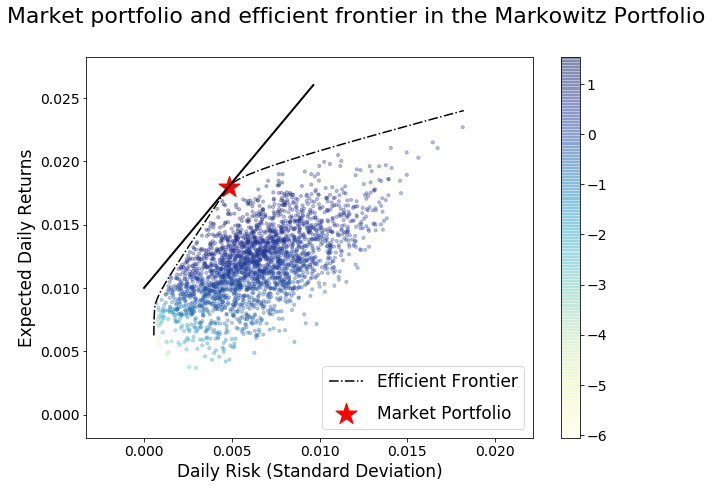

In [26]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [27]:
end_time = time.perf_counter()
print (end_time - start_time)

8.183473146999997


# Markowitz Protfolio Allocation Example

In [28]:
def neg_return(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_daily_performance(weights, mean_returns, cov_matrix)
    return (-p_ret)

# Optimizor to maximize returns
def max_return(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    # All in constraint
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Long only constraint
    bound = (0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_return, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [29]:
returns_all = prices_all.pct_change()

In [30]:
alpha = 0.89
returns = prices.pct_change()
# Markowitz Portolio Optimization
markowitz = returns.copy().loc[pd.to_datetime('2017-01-01'):,]
rf = (1+0.01)**(1/365)-1
train_window = 63
N = 4
for i in range(N):
    markowitz[markowitz.columns[i]+' Weight'] = 0

T = len(markowitz.index)
markowitz_SR = markowitz.copy()
markowitz.head(5)

,AAPL,GOOG,TSLA,MS,AAPL Weight,GOOG Weight,TSLA Weight,MS Weight
Date,,,,,,,,
2017-01-03,0.002849,0.018554,0.015443,0.018935,0,0,0,0
2017-01-04,-0.001119,0.000967,0.046085,0.013241,0,0,0,0
2017-01-05,0.005085,0.009048,-0.001057,-0.009170,0,0,0,0
2017-01-06,0.011148,0.015277,0.009967,0.014577,0,0,0,0
2017-01-09,0.009159,0.000620,0.009912,-0.025998,0,0,0,0


In [31]:
start_time = time.process_time()

# Rolling train and test data
# Use 63-day data to allocate weight for next day
# Use one-year exp smoothing return to estimate future one-day return, smoothing alpha=0.89
# Use last 63-day sd to estimate future one-day sd

for t in range(T-train_window-1):
    train_index = markowitz.index[t:t+train_window]
    train_data = markowitz.loc[train_index,keylist[0:N]]
    mean_returns = train_data.ewm(alpha=alpha,min_periods=train_window).mean().iloc[-1,]
    cov_matrix = train_data.ewm(alpha=alpha,min_periods=train_window).cov().iloc[-4:,]

    for i in range(N):
        # Maximize Return
        markowitz.loc[markowitz.index[t+train_window+1],markowitz.columns[i]+' Weight'] = \
            max_return(mean_returns, cov_matrix, rf).x[i]
        markowitz_SR.loc[markowitz.index[t+train_window+1],markowitz.columns[i]+' Weight'] = \
            max_sharpe_ratio(mean_returns, cov_matrix, rf).x[i]
        
end_time = time.process_time()
print (end_time-start_time)

246.5585


In [32]:
# Markowitz porfolio to maximize returns
drop_window = train_window

markowitz = markowitz.iloc[drop_window+1:,].copy()
markowitz['Daily return'] = 0
for i in range(N):
    markowitz['Daily return'] += markowitz.iloc[:,i]*markowitz.loc[:,markowitz.columns[i]+' Weight']
markowitz['Cum return'] = (1+markowitz['Daily return']).cumprod()
markowitz.tail(5)

,AAPL,GOOG,TSLA,MS,AAPL Weight,GOOG Weight,TSLA Weight,MS Weight,Daily return,Cum return
Date,,,,,,,,,,
2019-07-08,-0.020614,-0.013468,-0.011840,-0.016286,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,-0.011840,1.734254
2019-07-09,0.006099,0.007596,-0.001216,0.006668,2.567391e-16,1.000000e+00,0.000000,0.000000e+00,0.007596,1.747428
2019-07-10,0.009889,0.013913,0.038512,-0.010735,0.000000e+00,4.842445e-01,0.515756,0.000000e+00,0.026600,1.793910
2019-07-11,-0.007282,0.003271,-0.001339,0.020088,7.077672e-16,6.851095e-01,0.000000,3.148905e-01,0.008566,1.809277
2019-07-12,0.007683,0.000603,0.027158,0.015618,4.440892e-16,4.163336e-16,1.000000,3.700743e-17,0.027158,1.858414


In [33]:
# Markowitz porfolio to the Sharpe ratio
markowitz_SR = markowitz_SR.iloc[drop_window+1:,].copy()
markowitz_SR['Daily return'] = 0
for i in range(N):
    markowitz_SR['Daily return'] += markowitz_SR.iloc[:,i]*markowitz_SR.loc[:,markowitz_SR.columns[i]+' Weight']
markowitz_SR['Cum return'] = (1+markowitz_SR['Daily return']).cumprod()
markowitz_SR.tail(5)

,AAPL,GOOG,TSLA,MS,AAPL Weight,GOOG Weight,TSLA Weight,MS Weight,Daily return,Cum return
Date,,,,,,,,,,
2019-07-08,-0.020614,-0.013468,-0.011840,-0.016286,3.935003e-10,0.946988,5.301163e-02,2.114350e-12,-0.013382,0.971605
2019-07-09,0.006099,0.007596,-0.001216,0.006668,0.000000e+00,0.683724,2.678958e-03,3.135969e-01,0.007282,0.978680
2019-07-10,0.009889,0.013913,0.038512,-0.010735,3.469447e-17,1.000000,0.000000e+00,3.053113e-16,0.013913,0.992296
2019-07-11,-0.007282,0.003271,-0.001339,0.020088,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,0.003271,0.995542
2019-07-12,0.007683,0.000603,0.027158,0.015618,4.135581e-15,1.000000,3.619780e-15,2.095546e-15,0.000603,0.996142


In [34]:
markowitz.to_csv('markowitz_return.csv')
markowitz_SR.to_csv('markowitz_SR.csv')

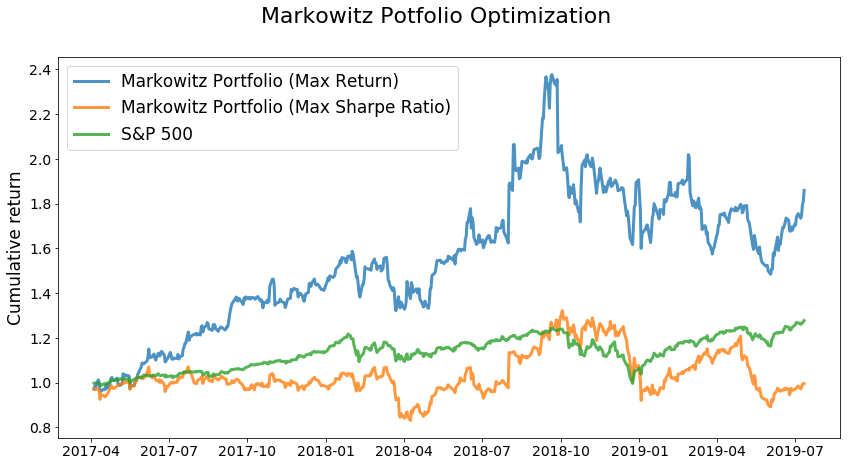

In [37]:
# Plot cumulative returns of two Markowitz portfolios
fig = plt.figure(figsize=(14, 7))
plt.plot(markowitz['Cum return'].index, markowitz['Cum return'], lw=3, alpha=0.8)
plt.plot(markowitz_SR['Cum return'].index, markowitz_SR['Cum return'], lw=3, alpha=0.8)
plt.plot(markowitz['Cum return'].index, (1+returns_all.loc[markowitz['Cum return'].index,'Market']).cumprod(), \
         lw=3, alpha=0.8)
plt.legend(labels = ('Markowitz Portfolio (Max Return)',\
                     'Markowitz Portfolio (Max Sharpe Ratio)',\
                     'S&P 500'),loc='upper left')
plt.ylabel('Cumulative return')
plt.suptitle('Markowitz Potfolio Optimization')
fig.savefig("Morkowitz_Example2.pdf")